In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

# EDA

In [4]:
df = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [5]:
df.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849974,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [7]:
df.isna().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

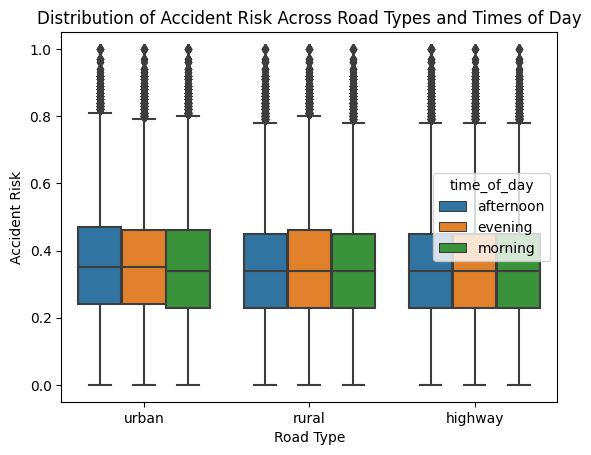

In [8]:
sns.boxplot(data=df, x='road_type', y='accident_risk', hue='time_of_day')
plt.title('Distribution of Accident Risk Across Road Types and Times of Day')
plt.xlabel('Road Type')
plt.ylabel('Accident Risk')
plt.show()

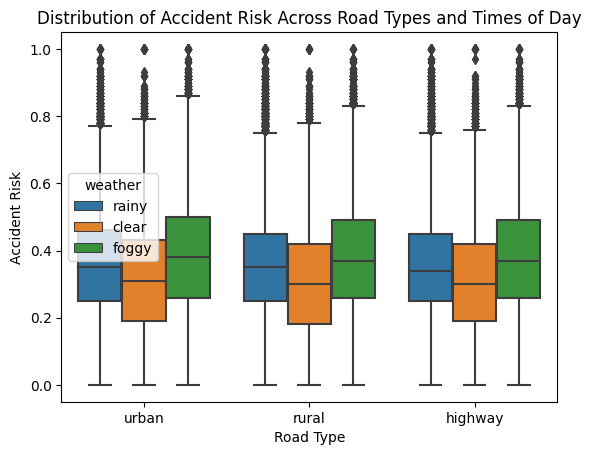

In [9]:
sns.boxplot(data=df, x='road_type', y='accident_risk', hue='weather')
plt.title('Distribution of Accident Risk Across Road Types and Times of Day')
plt.xlabel('Road Type')
plt.ylabel('Accident Risk')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='curvature', ylabel='accident_risk'>

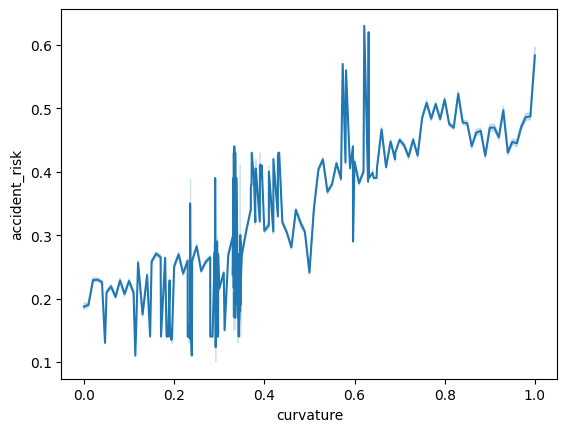

In [10]:
sns.lineplot(data=df, x='curvature', y='accident_risk')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_reported_accidents', ylabel='accident_risk'>

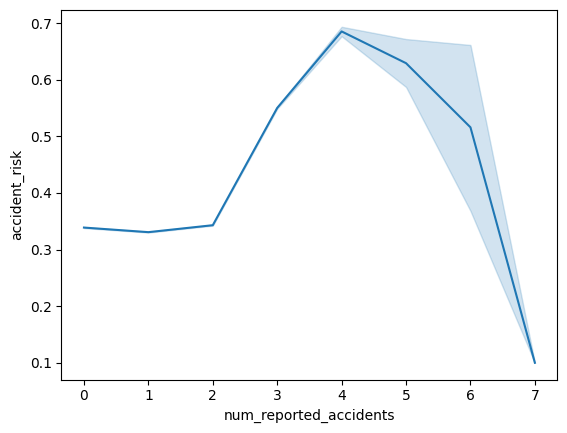

In [11]:
sns.lineplot(data=df, x='num_reported_accidents', y='accident_risk')

<Axes: xlabel='speed_limit', ylabel='accident_risk'>

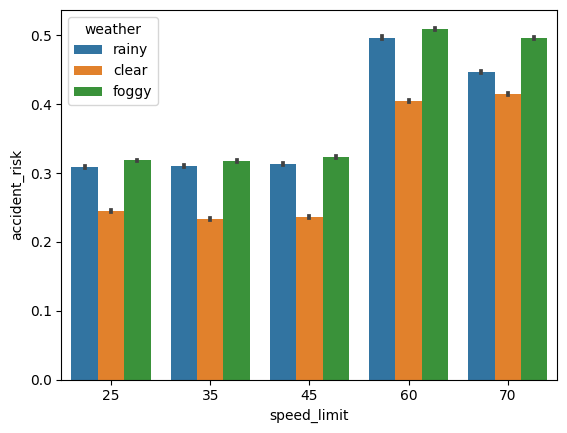

In [12]:
sns.barplot(data=df, x='speed_limit', y='accident_risk', hue='weather')

<Axes: xlabel='road_signs_present', ylabel='accident_risk'>

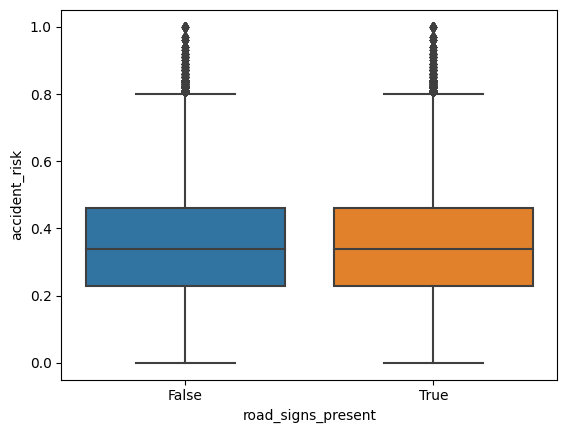

In [13]:
sns.boxplot(data=df, x='road_signs_present', y='accident_risk')

<Axes: xlabel='public_road', ylabel='accident_risk'>

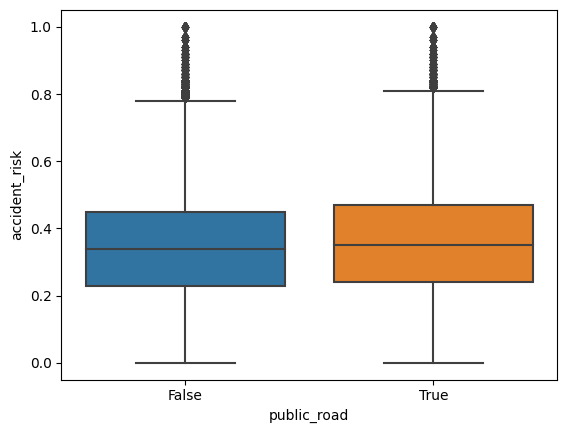

In [14]:
sns.boxplot(data=df, x='public_road', y='accident_risk')

<Axes: xlabel='num_lanes', ylabel='accident_risk'>

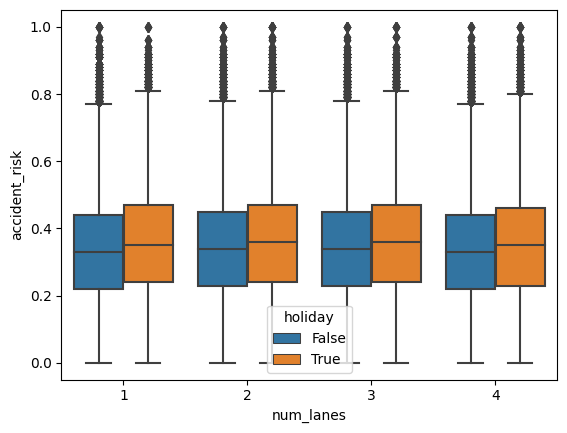

In [15]:
sns.boxplot(data=df, x='num_lanes', y='accident_risk', hue='holiday')

# Feature Selection

In [16]:
df.columns

Index(['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents', 'accident_risk'],
      dtype='object')

In [17]:
X = df[['curvature', 'speed_limit', 'public_road', 'weather', 'holiday', 'num_lanes', 'num_reported_accidents']]
y = df['accident_risk']

In [18]:
X.head()

,curvature,speed_limit,public_road,weather,holiday,num_lanes,num_reported_accidents
0,0.06,35,True,rainy,False,2,1
1,0.99,35,False,clear,True,4,0
2,0.63,70,True,clear,True,4,2
3,0.07,35,True,rainy,False,4,1
4,0.58,60,False,foggy,True,1,1


In [19]:
X = pd.get_dummies(X, columns=['weather'], drop_first=False)
X.head()

,curvature,speed_limit,public_road,holiday,num_lanes,num_reported_accidents,weather_clear,weather_foggy,weather_rainy
0,0.06,35,True,False,2,1,False,False,True
1,0.99,35,False,True,4,0,True,False,False
2,0.63,70,True,True,4,2,True,False,False
3,0.07,35,True,False,4,1,False,False,True
4,0.58,60,False,True,1,1,False,True,False


In [20]:
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)
X.head()

,curvature,speed_limit,public_road,holiday,num_lanes,num_reported_accidents,weather_clear,weather_foggy,weather_rainy
0,0.06,35,1,0,2,1,0,0,1
1,0.99,35,0,1,4,0,1,0,0
2,0.63,70,1,1,4,2,1,0,0
3,0.07,35,1,0,4,1,0,0,1
4,0.58,60,0,1,1,1,0,1,0


# Model Creation

In [21]:
model = XGBRegressor(seed=42)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape 

((388315, 9), (129439, 9), (388315,), (129439,))

In [24]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [25]:
y_hat = model.predict(X_val)

In [26]:
def get_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [27]:
get_rmse(y_hat, y_val)

0.09921247296997962

In [28]:
model2 = XGBRegressor(seed=42)

In [72]:
rmse_scorer = make_scorer(
    lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)),
    greater_is_better=False
)
params = [
    {
        'booster': ['gbtree'],
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.001, 0.005, 0.01],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0.2, 0.3],
        'min_child_weight': [3, 5],
        'reg_alpha': [0.1, 1],
        'reg_lambda': [0.5, 1]
    }
]

cv = GridSearchCV(
    estimator=model2,
    param_grid=params,
    scoring=rmse_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

cv.fit(X_train, y_train)

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits
[CV] END booster=gbtree, colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.6; total time=   3.1s
[CV] END booster=gbtree, colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0.1, reg_lambda=1, subsample=0.6; total time=   3.1s
[CV] END booster=gbtree, colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.1s
[CV] END booster=gbtree, colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=1, reg_lambda=0.5, subsample=0.6; total time=   3.0s
[CV] END booster=gbtree, colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=1, reg_lambda=1, subs

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END booster=gbtree, colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.6; total time=   3.1s
[CV] END booster=gbtree, colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   2.9s
[CV] END booster=gbtree, colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=0.1, reg_lambda=1, subsample=0.8; total time=   3.1s
[CV] END booster=gbtree, colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=1, reg_lambda=0.5, subsample=0.6; total time=   3.0s
[CV] END booster=gbtree, colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=3, min_child_weight=3, n_estimators=100, reg_alpha=1, reg_lambda=0.5, subsample=0.8; total time=   2.9s
[CV] END booster=gbtree, colsam

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=0.9073185623081986,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None,
                                    gamma=0.035667964456977626,
                                    grow_policy=None, importance_type=None,
                                    interaction_con...
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid=[{'booster': ['gbtree'], 'colsample_bytree': [0.8, 1.0],
                          'gamma': [0.2, 0.3],
                          'learning_rate': [0.001, 0.005, 0.01],
                          'max_depth': [3, 5, 7], 'min_child_weight': [3, 5],
                          'n_estimators': [100, 200], 'reg_alpha': [0.1, 1],
                          'reg_lambda': [0.5, 1], 'subsample': [0.6, 0.8]}],
             scoring=make_scorer(<lambda>, greater_is_better=False), verbose=2)

In [73]:
cv.best_estimator_

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [84]:
cv.best_score_

-0.10152078531486936

In [85]:
y_hat_val = cv.best_estimator_.predict(X_val)

In [86]:
get_rmse(y_hat_val, y_val)

0.10154291132347168

In [87]:
X_test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')
X_test.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


In [88]:
X_test_transform = X_test[['curvature', 'speed_limit', 'public_road', 'weather', 'holiday', 'num_lanes', 'num_reported_accidents']]
X_test_transform.head()

,curvature,speed_limit,public_road,weather,holiday,num_lanes,num_reported_accidents
0,0.34,45,True,clear,True,2,1
1,0.04,45,False,foggy,True,3,0
2,0.59,35,False,clear,True,2,1
3,0.95,35,False,rainy,False,4,2
4,0.86,35,False,clear,False,2,3


In [89]:
X_test_transform = pd.get_dummies(X_test_transform, columns=['weather'], drop_first=False)
bool_cols = X_test_transform.select_dtypes(include='bool').columns
X_test_transform[bool_cols] = X_test_transform[bool_cols].astype(int)
X_test_transform.head()

,curvature,speed_limit,public_road,holiday,num_lanes,num_reported_accidents,weather_clear,weather_foggy,weather_rainy
0,0.34,45,1,1,2,1,1,0,0
1,0.04,45,0,1,3,0,0,1,0
2,0.59,35,0,1,2,1,1,0,0
3,0.95,35,0,0,4,2,0,0,1
4,0.86,35,0,0,2,3,1,0,0


In [90]:
y_final = cv.best_estimator_.predict(X_test_transform)

In [91]:
submission = {"id":X_test["id"], "accident_risk":y_final}

In [92]:
submission = pd.DataFrame(submission)
submission.head()

,id,accident_risk
0,517754,0.208541
1,517755,0.222211
2,517756,0.275003
3,517757,0.335848
4,517758,0.481380


In [93]:
submission.to_csv("submission.csv", index=False)


[CV] END booster=gbtree, colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, reg_alpha=1, reg_lambda=0.5, subsample=0.6; total time=   8.4s
[CV] END booster=gbtree, colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=0.6; total time=   8.4s
[CV] END booster=gbtree, colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, reg_alpha=1, reg_lambda=1, subsample=0.8; total time=   8.2s
[CV] END booster=gbtree, colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, reg_alpha=0.1, reg_lambda=0.5, subsample=0.8; total time=   5.4s
[CV] END booster=gbtree, colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=100, reg_alpha=0.1, reg_lambda=1, subsample=0.6; total time=   5.8s
[CV] END booster=gbtree, colsample_bytree